# Binomial tree pricing and hedging 

In [100]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats

In [101]:
S0 = 100 
sigma = 0.3
r = b = 0.05 
T = 2  #years
n = 50
hn = T / n
u = np.exp(b * (hn) + sigma * (np.sqrt(hn)))
d = np.exp(b * (hn) - sigma * (np.sqrt(hn)))
u, d

(1.0639623447280337, 0.9436499474367985)

In [102]:
def Sn(T, n, b, sigma, j):
    Snj = np.zeros(j + 1)
    hn = T / n
    u = np.exp(b * (hn) + sigma * (np.sqrt(hn)))
    d = np.exp(b * (hn) - sigma * (np.sqrt(hn)))
    for i in range(j+1):
        Snji = S0 * (d ** (j - i)) * (u ** i) 
        Snj[i] = Snji 
    return Snj

In [103]:
def Payoffn(T, n, b, sigma, K):
    return np.maximum(Sn(T, n, b, sigma, n) - K , 0)  

In [104]:
def Calln(T, n, r, b, sigma, K):
    hn = T / n
    u = np.exp(b * (hn) + sigma * (np.sqrt(hn)))
    d = np.exp(b * (hn) - sigma * (np.sqrt(hn)))
    p = (1 + r * hn - d) / (u - d)   #proba risque neutre
    q = 1 - p
    calln = 0
    for i in range(n + 1):
        calln += np.maximum(S0 * (u ** (n-i)) *  (d ** i) - K, 0) * (q ** i) * (p ** (n - i)) * math.comb(n, i)
    return (1 + r * hn) ** (-n) * calln

In [105]:
def Deltan(T, n, r, b, sigma, K, j):
    hn = T / n
    u = np.exp(b * (hn) + sigma * (np.sqrt(hn)))
    d = np.exp(b * (hn) - sigma * (np.sqrt(hn)))
    p = (1 + r * hn - d) / (u - d)   #proba risque neutre
    q = 1 - p
    B = np.zeros((n+1, n+1))
    B[n] = Payoffn(T, n, b, sigma, K)
    for k in range(n, -1, -1): 
        for i in range(k):
            B[k - 1][i] = (p * B[k][i + 1] + q * B[k][i]) * np.exp(-r * hn) 
    deltanj = np.zeros(j)
    for i in range(j):
        deltanj[i] = (B[j + 1][i + 1] - B[j + 1][i]) / (Sn(T, n, b, sigma, j)[i] * (u - d))
    return deltanj
       

In [106]:
Ks = np.arange(80, 121, 1)
ycall = Calln(T, n, r, b, sigma, Ks)

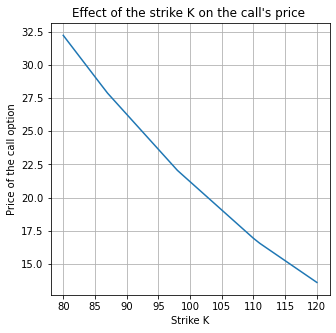

In [107]:
plt.figure(figsize=(5,5))
plt.plot(Ks, ycall)
plt.xlabel("Strike K")
plt.ylabel("Price of the call option")
plt.title('Effect of the strike K on the call\'s price ')
plt.grid()
plt.show()

In [108]:
Ks0 = np.arange(80, 300, 1)
ycall = Calln(T, n, r, b, sigma, Ks0)

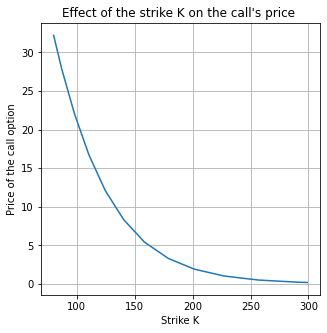

In [109]:
plt.figure(figsize=(5,5))
plt.plot(Ks0,ycall)
plt.xlabel("Strike K")
plt.ylabel("Price of the call option")
plt.title('Effect of the strike K on the call\'s price ')
plt.grid()
plt.show()

In [110]:
Js=np.arange(1,32,5)
delta_up = np.zeros((len(Ks),len(Js)))
delta_down = np.zeros((len(Ks),len(Js)))
delta_mid = np.zeros((len(Ks),len(Js)))
for i in range(len(Ks)):
    for k,j in enumerate(Js) : 
        delta_mid[i,k] = Deltan(T, n, r, b, sigma, Ks[i], j)[j // 2]
        delta_up[i,k] = Deltan(T, n, r, b, sigma, Ks[i], j)[-1]
        delta_down[i,k] = Deltan(T, n, r, b, sigma, Ks[i], j)[0]

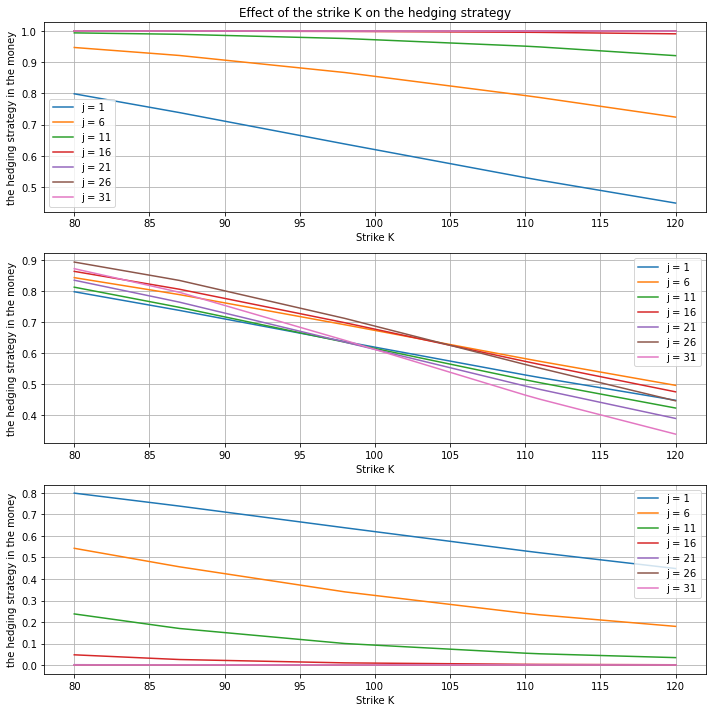

In [111]:
plt.figure(figsize=(10,10))
plt.subplot(3, 1, 1)
plt.grid()
plt.title('Effect of the strike K on the hedging strategy')
plt.plot(Ks, delta_up)
plt.xlabel("Strike K")
plt.ylabel("the hedging strategy in the money")
plt.legend(['j = {j}'.format(j = j) for j in Js ])
plt.subplot(3, 1, 2)
plt.grid()
plt.plot(Ks, delta_mid)
plt.xlabel("Strike K")
plt.ylabel("the hedging strategy in the money")
plt.legend(['j = {j}'.format(j = j) for j in Js ])
plt.subplot(3, 1, 3)
plt.plot(Ks, delta_down)
plt.xlabel("Strike K")
plt.ylabel("the hedging strategy in the money")
plt.legend(['j = {j}'.format(j = j) for j in Js ])
plt.grid()


plt.tight_layout()
plt.show()

In [112]:
def Call(T, r, sigma, K):
    d1 = (np.log(S0 / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    N1 = stats.norm.cdf(d1)
    N2 = stats.norm.cdf(d2)
    call = S0 * N1 - K * np.exp(-r * T) * N2
    return(call)

In [113]:
def err(T, r, n, b, sigma, K):
    calln = Calln(T, n, r, b, sigma, K)
    call = Call(T, r, sigma, K)
    return calln / call - 1

In [114]:
K = 105
errors = [err(T, r, n, b, sigma, K) for n in range(1,151)] 

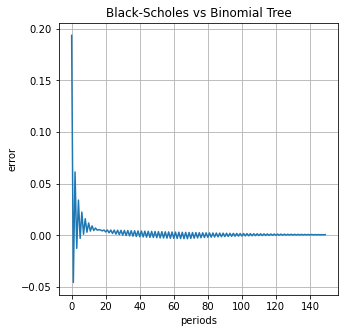

In [115]:
plt.figure(figsize=(5,5))
plt.plot(errors)
plt.xlabel("periods")
plt.ylabel("error")
plt.title('Black-Scholes vs Binomial Tree')
plt.grid()
plt.show()

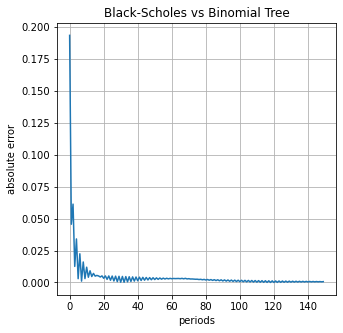

In [116]:
plt.figure(figsize=(5,5))
plt.plot(np.abs(errors))
plt.xlabel("periods")
plt.ylabel("absolute error")
plt.title('Black-Scholes vs Binomial Tree')
plt.grid()
plt.show()

The error converge to 0 as n  $\rightarrow +\infty$, which is expected as the binomial tree prices of the European call option  converge to the Black-Scholes prices, we can see that there are fluctuations that depends on the parity of the period n, so I decided to plot the error for both odd and even binomial trees.

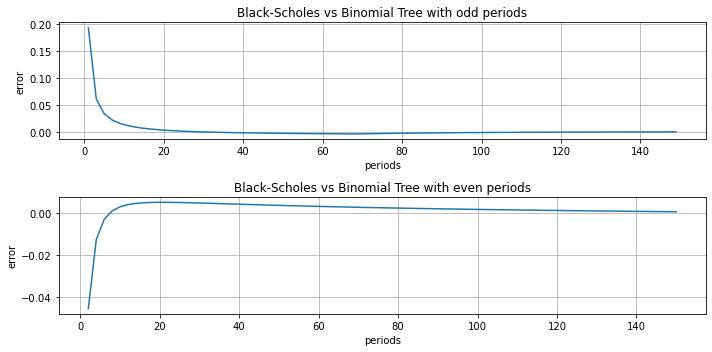

In [78]:
x_even=np.arange(2,151,2)
x_odd=np.arange(1,151,2)
plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plt.plot(x_odd,errors[::2])
plt.xlabel("periods")
plt.ylabel("error")
plt.title('Black-Scholes vs Binomial Tree with odd periods')
plt.grid()

plt.subplot(2,1,2)
plt.plot(x_even,errors[1::2])
plt.xlabel("periods")
plt.ylabel("error")
plt.title('Black-Scholes vs Binomial Tree with even periods')
plt.grid()


plt.tight_layout()
plt.show()

The error between Black-Scholes and Binomial tree prices using odd periods tend to 0 much faster ($\sim 25$) than the even periods ($\sim 150$), so we can conclude thats its more efficient to use an odd period. 

P.S = interesting result especially that we intuitively choose an even period (for exemple we should take n=51 or 49 instead of 50 which unnatural).